In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import ravel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Buildng model on One Hot Encoded Data with Lassocv Features

In [4]:
#read data
data_ohe = pd.read_csv('C:/application/interview_prep/bank-additional/bank-additional/bank_full_processed.csv')  
# visualize the data
data_ohe.head()

,age,default,housing,loan,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_missing,pdays_less_5,pdays_greater_15,pdays_bet_5_15,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,contact_cellular,month_apr,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,0.481481,1,1,1,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.493827,0,1,1,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.246914,1,-1,1,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.283951,1,1,1,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.481481,1,1,-1,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# Model Building and Evaluation


- **Train Test Split** : Divide the Data set into Train class and Test class for model building and Evaluation


- Used **Stratification split** since the data is imbalanced. A random split might probably have changed the target distribution 

In [5]:
X_ohe = data_ohe.drop('y', axis=1)
y_ohe = data_ohe['y']

In [6]:
X_ohe = data_ohe[[ "cons.price.idx", "cons.conf.idx", "euribor3m", "poutcome", "month_mar", "pdays_less_5", "job_retired", "job_student", "campaign", "default"]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, test_size=0.2, stratify=y_ohe, random_state=1)
print('Original:', (data_ohe.y).mean(), 'Train:', (y_train).mean(), 'Test:', (y_test).mean())

Original: 0.11265417111780131 Train: 0.11265553869499241 Test: 0.11264870114105366


# Performing Logistic Regression as Base Model

- Performing a Base Model Evaluation will help to understand the data , whether or not the data is good to be fitted in a Machine learning algorithm

In [8]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    try:
        feature_importances = np.mean([tree.feature_importances_ for tree in algo.estimators_], axis=0)
    except:
        feature_importances = 'none'
    
    return train_pred, test_pred, acc, acc_cv, probs,feature_importances

In [9]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
def make_confusion_matrix(y,y_pred,categories='auto',count=True,percent=True,cbar=True,xyticks=True,
                          figsize=(7,7),cmap='Blues',title=None):
    cf = confusion_matrix(y, y_pred)
    blanks = ['' for i in range(cf.size)]
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['No', 'Yes']

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        cm_sum = np.sum(cf, axis=1, keepdims=True)
        cm_perc = cf / cm_sum.astype(float) * 100
        annot = np.empty_like(cf).astype(str)
        nrows, ncols = cf.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cf[i, j]
            #p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%d/%d\n' % (c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%d\n' % (c)
        group_counts = list(annot.flat)
        
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
     # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title:
        plt.title(title)

Accuracy before CV: 89.73
Accuracy CV 10-Fold: 89.79
Running Time for the Algorithm to train and pred: 0:00:12.628247


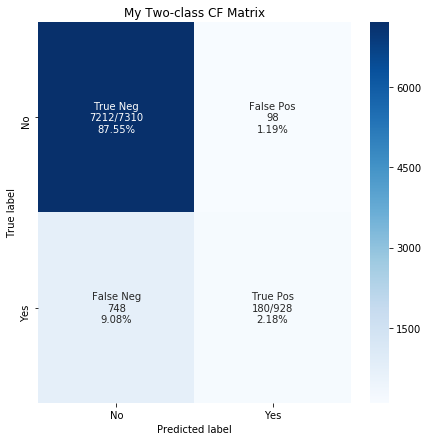

In [11]:
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log,feature_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print('\033[1m' + "Accuracy before CV: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=log_time))
make_confusion_matrix(y_test,test_pred_log, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.91      0.99      0.94     29238
           1       0.65      0.20      0.30      3712

    accuracy                           0.90     32950
   macro avg       0.78      0.59      0.62     32950
weighted avg       0.88      0.90      0.87     32950

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7310
           1       0.65      0.19      0.30       928

    accuracy                           0.90      8238
   macro avg       0.78      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238

ROC and AUC curve :-


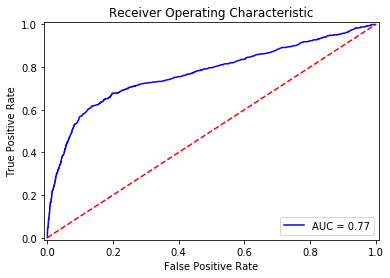

In [12]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_log))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_log))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_log)

# Buildng model on Label Encoded Data with Lassocv Features

In [13]:
#read data
data_le = pd.read_csv('C:/application/interview_prep/bank-additional/bank-additional/bank_full_processed_le.csv')  
# visualize the data
data_le.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_missing,pdays_less_5,pdays_greater_15,pdays_bet_5_15
0,0.481481,3,1,0,2,2,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
1,0.493827,7,1,3,1,2,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
2,0.246914,7,1,3,2,0,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
3,0.283951,0,1,1,2,2,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
4,0.481481,7,1,3,2,2,0,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0


# Model Building and Evaluation


- **Train Test Split** : Divide the Data set into Train class and Test class for model building and Evaluation


- Used **Stratification split** since the data is imbalanced. A random split might probably have changed the target distribution 

In [14]:
X_ohe = data_le.drop('y', axis=1)
y_le = data_le['y']
X_le = data_le[["cons.price.idx", "cons.conf.idx", "euribor3m", "campaign", "poutcome"]]
X_train, X_test, y_train, y_test = train_test_split(X_le, y_le, test_size=0.2, stratify=y_le, random_state=1)
print('Original:', (data_le.y).mean(), 'Train:', (y_train).mean(), 'Test:', (y_test).mean())

Original: 0.11265417111780131 Train: 0.11265553869499241 Test: 0.11264870114105366


# Performing Logistic Regression as Base Model

- Performing a Base Model Evaluation will help to understand the data , whether or not the data is good to be fitted in a Machine learning algorithm

Accuracy before CV: 89.91
Accuracy CV 10-Fold: 89.85
Running Time for the Algorithm to train and pred: 0:00:01.154082


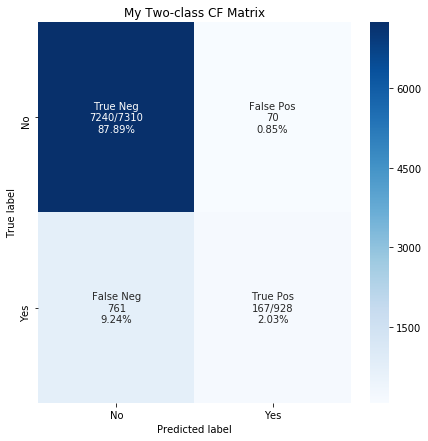

In [15]:
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log,feature_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print('\033[1m' + "Accuracy before CV: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=log_time))
make_confusion_matrix(y_test,test_pred_log, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     29238
           1       0.69      0.18      0.29      3712

    accuracy                           0.90     32950
   macro avg       0.80      0.58      0.62     32950
weighted avg       0.88      0.90      0.87     32950

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      7310
           1       0.70      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.80      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238

ROC and AUC curve :-


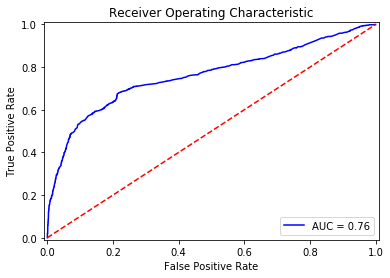

In [16]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_log))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_log))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_log)

# Conclusion on Base Model

- The base model shows that the data **can be used to train machine learning algorithms** giving an accuracy of 89% but the model evaluation also suggests that the **current features are not able to capture the variance** of the entire dataset in proper sense which is reflected b the **AUC value "0.77"**


- The next step will be building ML Models with a **different feature** which will take **maximum variance of the data** in consideration

- Additionally trying to train the data on different ML Algorithms to improve the **precision and recall** 


- Comparing both the Encoding Techniques it is observed that both the encodings perform similarily on simple linear regression algorithm considering the recall and AUC 


- So we will try building models using both the encoding techniques and see which TOC and AUC curvers are better
